<a target="_blank" href="https://colab.research.google.com/github/neelnanda-io/TransformerLens/blob/main/demos/Interactive_Neuroscope.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Interactive Neuroscope

*This is an interactive accompaniment to [neuroscope.io](https://neuroscope.io) and to the [studying learned language features post](https://www.alignmentforum.org/posts/Qup9gorqpd9qKAEav/200-cop-in-mi-studying-learned-features-in-language-models) in [200 Concrete Open Problems in Mechanistic Interpretability](https://neelnanda.io/concrete-open-problems)*

There's a surprisingly rich ecosystem of easy ways to create interactive graphics, especially for ML systems. If you're trying to do mechanistic interpretability, the ability to do web dev and to both visualize data and interact with it seems high value!

This is a demo of how you can combine HookedTransformer and [Gradio](https://gradio.app/) to create an interactive Neuroscope - a visualization of a neuron's activations on text that will dynamically update as you edit the text. I don't particularly claim that this code is any *good*, but the goal is to illustrate what quickly hacking together a custom visualisation (while knowing fuck all about web dev, like me) can look like! (And as such, I try to explain the basic web dev concepts I use)

Note that you'll need to run the code yourself to get the interactive interface, so the cell at the bottom will be blank at first!

To emphasise - the point of this notebook is to be a rough proof of concept that just about works, *not* to be the well executed ideal of interactively studying neurons! You are highly encouraged to write your own (and ideally, to [make a pull request](https://github.com/neelnanda-io/TransformerLens/pulls) with improvements!)

## Setup

In [1]:
# NBVAL_IGNORE_OUTPUT
# Janky code to do different setup when run in a Colab notebook vs VSCode
import os

DEVELOPMENT_MODE = True
IN_GITHUB = os.getenv("GITHUB_ACTIONS") == "true"
try:
    import google.colab

    IN_COLAB = True
    print("Running as a Colab notebook")
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

if IN_COLAB or IN_GITHUB:
    %pip install transformer_lens
    %pip install gradio
    %pip install datasets==2.19.1

Running as a Colab notebook
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.6/176.6 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.7/739.7 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.0
    Uninstalling typeguard-4.4.0:
      Successfully uninstalled typeguard-4.4.0
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERR

In [2]:
import gradio as gr
from transformer_lens import HookedTransformer
from transformer_lens.utils import to_numpy
from IPython.display import HTML

## Extracting Model Activations

In this section, we’ll use the HookedTransformer model to extract neuron activations for specific layers and neurons in response to given text inputs. This process is essential for analyzing how different parts of the model respond to various text patterns.

* We begin by loading a pre-trained transformer model, gpt2-small, through the HookedTransformer library. This model is configured with “hooks” that allow us to access its internal computations, like neuron activations, at any layer.

* We use GPT-2 here because it is a transformer model trained on large-scale language data. It has multiple layers and neurons, making it suitable for understanding complex language features.

In [3]:
# NBVAL_IGNORE_OUTPUT
model_name = "gpt2-small"
model = HookedTransformer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loaded pretrained model gpt2-small into HookedTransformer


**Defining the get_neuron_acts Function:**

* This function takes in three parameters: text, layer, and neuron_index.
* text: The input text we want to analyze.
* layer: The specific layer in the model where we want to examine neuron activations.
* neuron_index: The index of the neuron within that layer that we’re focusing on.
* The function extracts the activation of a specific neuron when the model processes the input text.

**Understanding the Hook Mechanism:**
* Hooks allow us to “listen in” on specific points in the model’s processing. In this case, we create a caching_hook function to capture neuron activations from the designated layer.

* Why Hooks? Hooks are useful because they let us access intermediate values within the model without changing its architecture. Here, we use a hook to capture and store the activation of a particular neuron.


After defining the function, you can use it to examine neuron activations for specific layers and neurons.
* For example, passing in a piece of text and specifying a layer and neuron index allows you to see how this neuron “reacts” to the input text.

* Application: By studying activations, we can begin to understand the “role” of each neuron, such as detecting certain linguistic features or patterns.

This function is a “hacky” way of extracting specific neuron activations using hooks. It’s straightforward and efficient, which makes it effective for quickly observing how a neuron behaves in response to various inputs.

In [4]:
def get_neuron_acts(text, layer, neuron_index):
    # Hacky way to get out state from a single hook - we have a single element list and edit that list within the hook.
    cache = {}

    def caching_hook(act, hook):
        cache["activation"] = act[0, :, neuron_index]

    model.run_with_hooks(
        text, fwd_hooks=[(f"blocks.{layer}.mlp.hook_post", caching_hook)]
    )
    return to_numpy(cache["activation"])

We can run this function and verify that it gives vaguely sensible outputs

**Choosing the Layer and Neuron:**

* Here, we set default_layer to 9 and default_neuron_index to 652. This means we’ll examine the activation of neuron 652 in layer 9 of the model.
* Layers and neurons in transformer models are hierarchically interconnected, meaning specific layers and neurons might capture different linguistic or semantic patterns in the input.

**Defining the Input Text:**
* The input text, default_text, is a sentence that includes a sequence of numbers in powers of ten. This choice of text is intended to test how neurons react to numeric patterns.
* Transformers are sensitive to various language patterns, and numbers can sometimes activate specific neurons more strongly.

**Tokenizing the Text:**
* The function model.to_str_tokens() is used to tokenize default_text. This splits the text into individual tokens, which are the basic units that the transformer processes.
* Tokenization is a fundamental step in NLP models, as it allows the model to understand each part of the sentence separately.

In [5]:
default_layer = 9
default_neuron_index = 652
default_text = "The following is a list of powers of 10: 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000"
print(model.to_str_tokens(default_text))

['<|endoftext|>', 'The', ' following', ' is', ' a', ' list', ' of', ' powers', ' of', ' 10', ':', ' 1', ',', ' 10', ',', ' 100', ',', ' 1000', ',', ' 10000', ',', ' 100', '000', ',', ' 100', '0000', ',', ' 100', '00000']


In [6]:
# NBVAL_IGNORE_OUTPUT
print(get_neuron_acts(default_text, default_layer, default_neuron_index))

[-0.08643502 -0.14071973 -0.10398166 -0.12390731 -0.04058984 -0.11064894
 -0.05189846 -0.11276122 -0.06905442 -0.11189385 -0.03059194 -0.10336886
 -0.04322356  1.5935527  -0.1420575   2.5116603  -0.13316427  2.5196702
 -0.11360849  3.0765235  -0.11637449  0.5393868   2.3499649  -0.14952144
 -0.16476344  1.9449062  -0.13690147 -0.08802463  2.184885  ]


Each number in this list corresponds to the “activation” of neuron 652 for a single token in the input text. Activations are numerical values that indicate how much this neuron “responds” to each token.

**In general:**
* Positive values suggest stronger activation, meaning the neuron is more engaged or “interested” in that token.
* Negative or low values indicate weak or negative activation, meaning the neuron isn’t particularly responsive to that token.

**The reason Activations Vary Across Tokens** is because different tokens in the input text trigger different responses from the neuron. For example, a neuron might react strongly to numbers, punctuation, or specific words. By observing these variations, we can begin to hypothesize what patterns or features this neuron is sensitive to.

* The first few values are relatively close to zero (e.g., -0.086, -0.141), which suggests that this neuron isn’t particularly responsive to the initial tokens in the sentence.
* Later values, such as 1.5935613 and 2.511661, indicate a much stronger activation. This suggests that specific tokens (possibly numbers in the list of powers) are triggering a significant response in the neuron.
* Observing these higher activations near the end of the list, where numbers appear in the input, might indicate that neuron 652 is sensitive to numerical or list-like patterns.

## Visualizing Model Activations

We now write some code to visualize the neuron activations on some text - we're going to hack something together which just does some string processing to make an HTML string, with each token element colored according to the intensity neuron activation. We normalize the neuron activations so they all lie in [0, 1]. You can do much better, but this is a useful proof of concept of what "just hack stuff together" can look like!

I'll be keeping neuron 562 in layer 9 as a running example, as it seems to activate strongly on powers of 10.

Note that this visualization is very sensitive to `max_val` and `min_val`! You can tune those to whatever seems reasonable for the distribution of neuron activations you care about - I generally default to `min_val=0` and `max_val` as the max activation across the dataset.

In [7]:
# This is some CSS (tells us what style )to give each token a thin gray border, to make it easy to see token separation
style_string = """<style>
    span.token {
        border: 1px solid rgb(123, 123, 123)
        }
    </style>"""


def calculate_color(val, max_val, min_val):
    # Hacky code that takes in a value val in range [min_val, max_val], normalizes it to [0, 1] and returns a color which interpolates between slightly off-white and red (0 = white, 1 = red)
    # We return a string of the form "rgb(240, 240, 240)" which is a color CSS knows
    normalized_val = (val - min_val) / max_val
    return f"rgb(240, {240*(1-normalized_val)}, {240*(1-normalized_val)})"


def basic_neuron_vis(text, layer, neuron_index, max_val=None, min_val=None):
    """
    text: The text to visualize
    layer: The layer index
    neuron_index: The neuron index
    max_val: The top end of our activation range, defaults to the maximum activation
    min_val: The top end of our activation range, defaults to the minimum activation

    Returns a string of HTML that displays the text with each token colored according to its activation

    Note: It's useful to be able to input a fixed max_val and min_val, because otherwise the colors will change as you edit the text, which is annoying.
    """
    if layer is None:
        return "Please select a Layer"
    if neuron_index is None:
        return "Please select a Neuron"
    acts = get_neuron_acts(text, layer, neuron_index)
    act_max = acts.max()
    act_min = acts.min()
    # Defaults to the max and min of the activations
    if max_val is None:
        max_val = act_max
    if min_val is None:
        min_val = act_min
    # We want to make a list of HTML strings to concatenate into our final HTML string
    # We first add the style to make each token element have a nice border
    htmls = [style_string]
    # We then add some text to tell us what layer and neuron we're looking at - we're just dealing with strings and can use f-strings as normal
    # h4 means "small heading"
    htmls.append(f"<h4>Layer: <b>{layer}</b>. Neuron Index: <b>{neuron_index}</b></h4>")
    # We then add a line telling us the limits of our range
    htmls.append(
        f"<h4>Max Range: <b>{max_val:.4f}</b>. Min Range: <b>{min_val:.4f}</b></h4>"
    )
    # If we added a custom range, print a line telling us the range of our activations too.
    if act_max != max_val or act_min != min_val:
        htmls.append(
            f"<h4>Custom Range Set. Max Act: <b>{act_max:.4f}</b>. Min Act: <b>{act_min:.4f}</b></h4>"
        )
    # Convert the text to a list of tokens
    str_tokens = model.to_str_tokens(text)
    for tok, act in zip(str_tokens, acts):
        # A span is an HTML element that lets us style a part of a string (and remains on the same line by default)
        # We set the background color of the span to be the color we calculated from the activation
        # We set the contents of the span to be the token
        htmls.append(
            f"<span class='token' style='background-color:{calculate_color(act, max_val, min_val)}' >{tok}</span>"
        )

    return "".join(htmls)

In [8]:
# NBVAL_IGNORE_OUTPUT
# The function outputs a string of HTML
default_max_val = 4.0
default_min_val = 0.0
default_html_string = basic_neuron_vis(
    default_text,
    default_layer,
    default_neuron_index,
    max_val=default_max_val,
    min_val=default_min_val,
)

# IPython lets us display HTML
print("Displayed HTML")
display(HTML(default_html_string))

# We can also print the string directly
print("HTML String - it's just raw HTML code!")
print(default_html_string)

Displayed HTML


HTML String - it's just raw HTML code!
<style> 
    span.token {
        border: 1px solid rgb(123, 123, 123)
        } 
    </style><h4>Layer: <b>9</b>. Neuron Index: <b>652</b></h4><h4>Max Range: <b>4.0000</b>. Min Range: <b>0.0000</b></h4><h4>Custom Range Set. Max Act: <b>3.0765</b>. Min Act: <b>-0.1648</b></h4><span class='token' style='background-color:rgb(240, 245.1861011981964, 245.1861011981964)' ><|endoftext|></span><span class='token' style='background-color:rgb(240, 248.44318360090256, 248.44318360090256)' >The</span><span class='token' style='background-color:rgb(240, 246.23889952898026, 246.23889952898026)' > following</span><span class='token' style='background-color:rgb(240, 247.43443831801414, 247.43443831801414)' > is</span><span class='token' style='background-color:rgb(240, 242.43539057672024, 242.43539057672024)' > a</span><span class='token' style='background-color:rgb(240, 246.6389362514019, 246.6389362514019)' > list</span><span class='token' style='background-co

In this cell, we visualize how a specific neuron (Neuron 652 in Layer 9) activates in response to each token in our input text using an HTML display.

* Setting Activation Range: default_max_val and default_min_val define the range for activation levels. The values help color-code activations, where higher values are shown with darker colors, indicating stronger neuron responses.
* Generating HTML Visualization: We use the basic_neuron_vis function to create an HTML string. This function takes the input text, layer, neuron index, and color range and returns HTML with each token wrapped in a span element styled based on its activation value.
* Displaying HTML: By using display(HTML(default_html_string)), we render the HTML output directly in the notebook. Tokens with higher neuron activation levels appear in darker colors (e.g., red), making it easy to identify which parts of the text the neuron reacts to most.
* Interpreting the Visualization: This color-coded display helps us quickly observe neuron behavior, showing which tokens (e.g., numbers or keywords) activate the neuron strongly, revealing potential patterns in its responses.

In [17]:
import matplotlib.pyplot as plt

def plot_neuron_activation_line(text, layer, neuron_index):
    """
    Plots a line chart of neuron activations for a specific neuron across all tokens in the input text.

    Parameters:
    - text: The input text to visualize
    - layer: The layer index of the neuron
    - neuron_index: The neuron index within the layer
    """
    # Get neuron activations
    activations = get_neuron_acts(text, layer, neuron_index)

    # Get tokens for labeling
    tokens = model.to_str_tokens(text)

    # Plotting the activations # Moved plotting code inside the function
    plt.figure(figsize=(10, 4))
    plt.plot(activations, marker='o', linestyle='-')
    plt.title(f'Activation Levels for Neuron {neuron_index} in Layer {layer}')
    plt.xlabel('Token Position')
    plt.ylabel('Activation Value')
    plt.xticks(range(len(tokens)), tokens, rotation=90)
    plt.grid(True)
    plt.show()

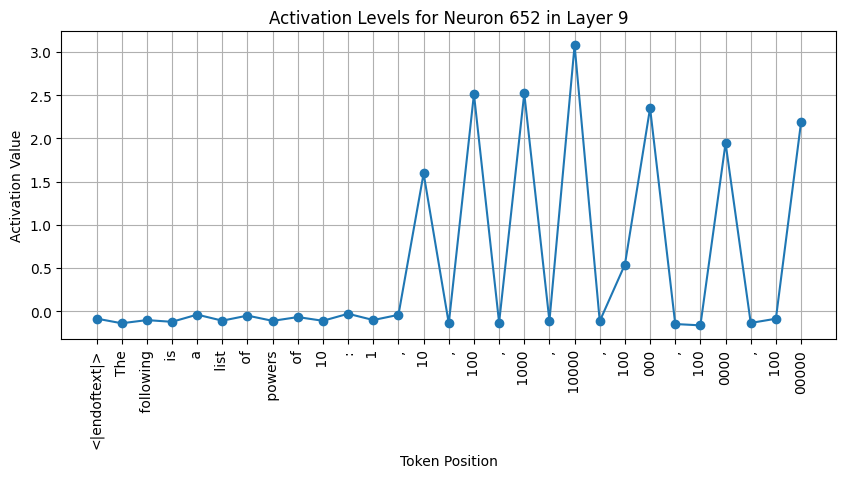

In [18]:
plot_neuron_activation_line(default_text, default_layer, default_neuron_index)

## Create Interactive UI

We now put all these together to create an interactive visualization in Gradio!

The internal format is that there's a bunch of elements - Textboxes, Numbers, etc which the user can interact with and which return strings and numbers. And we can also define output elements that just display things - in this case, one which takes in an arbitrary HTML string. We call `input.change(update_function, inputs, output)` - this says "if that input element changes, run the update function on the value of each of the elements in `inputs` and set the value of `output` to the output of the function". As a bonus, this gives us live interactivity!

This is also more complex than a typical Gradio intro example - I wanted to use custom HTML to display the nice colours, which made things much messier! Normally you could just make `out` into another Textbox and pass it a string.

In [9]:
# The `with gr.Blocks() as demo:` syntax just creates a variable called demo containing all these components
with gr.Blocks() as demo:
    gr.HTML(value=f"Hacky Interactive Neuroscope for {model_name}")
    # The input elements
    with gr.Row():
        with gr.Column():
            text = gr.Textbox(label="Text", value=default_text)
            # Precision=0 makes it an int, otherwise it's a float
            # Value sets the initial default value
            layer = gr.Number(label="Layer", value=default_layer, precision=0)
            neuron_index = gr.Number(
                label="Neuron Index", value=default_neuron_index, precision=0
            )
            # If empty, these two map to None
            max_val = gr.Number(label="Max Value", value=default_max_val)
            min_val = gr.Number(label="Min Value", value=default_min_val)
            inputs = [text, layer, neuron_index, max_val, min_val]
        with gr.Column():
            # The output element
            out = gr.HTML(label="Neuron Acts", value=default_html_string)
    for inp in inputs:
        inp.change(basic_neuron_vis, inputs, out)

We can now launch our demo element, and we're done! The setting share=True even gives you a public link to the demo (though it just redirects to the backend run by this notebook, and will go away once you turn the notebook off!) Sharing makes it much slower, and can be turned off if you aren't in a colab.

**Exercise:** Explore where this neuron does and does not activate. Is it just powers of ten? Just comma separated numbers? Numbers in any particular sequence?

In [10]:
# NBVAL_IGNORE_OUTPUT
demo.launch(share=True, height=1000)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c71229a5a55fec11f4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
